In [43]:
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
from helper_fns import yaml_load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from robot import Robot
from contact import Contact
from impedance_controller import ImpedanceController
from decision_vars import DecisionVarSet
par = {'pos': [0, 0, 0.0],
       'stiff': [0, 0, 100],
        'rest':[0, 0, 0.2]}
attrs = yaml_load('config/attrs.yaml')
attrs = {k:attrs[k] for k in ['lb', 'ub']}
c = Contact('c/', par, [], attrs=attrs)
imp = ImpedanceController(pars={'imp_stiff':[300, 300, 300], 'imp_rest':[0, 0, 0.5]}, 
                          sym_vars = ['imp_rest', 'imp_stiff'],
                          attrs = attrs)
rob = Robot('config/franka.urdf', subsys = [], ctrl = imp, attrs = attrs)
rob.build_step(0.1)


Building robot model from config/franka.urdf with TCP fr3_link8
  Building controller imp_ctrl


In [70]:
from mpc import MPC
from helper_fns import mult_shoot_rollout

mpc = MPC(robots={'free':rob}, mpc_params={'H':20, 'dt':0.1})
params = {'init_state': ca.DM.zeros(14), 
          'belief_free':1.0, 
          'imp_stiff':200*ca.DM.ones(3),}
res = mpc.solve(params)
traj = rob.get_ext_state_from_traj(res['xi'])

  Building controller imp_ctrl
This is Ipopt version 3.11.9, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4555
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1883

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equality constraints.................:      280
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(r

dict_keys(['q', 'dq', 'p', 'R', 'dx'])


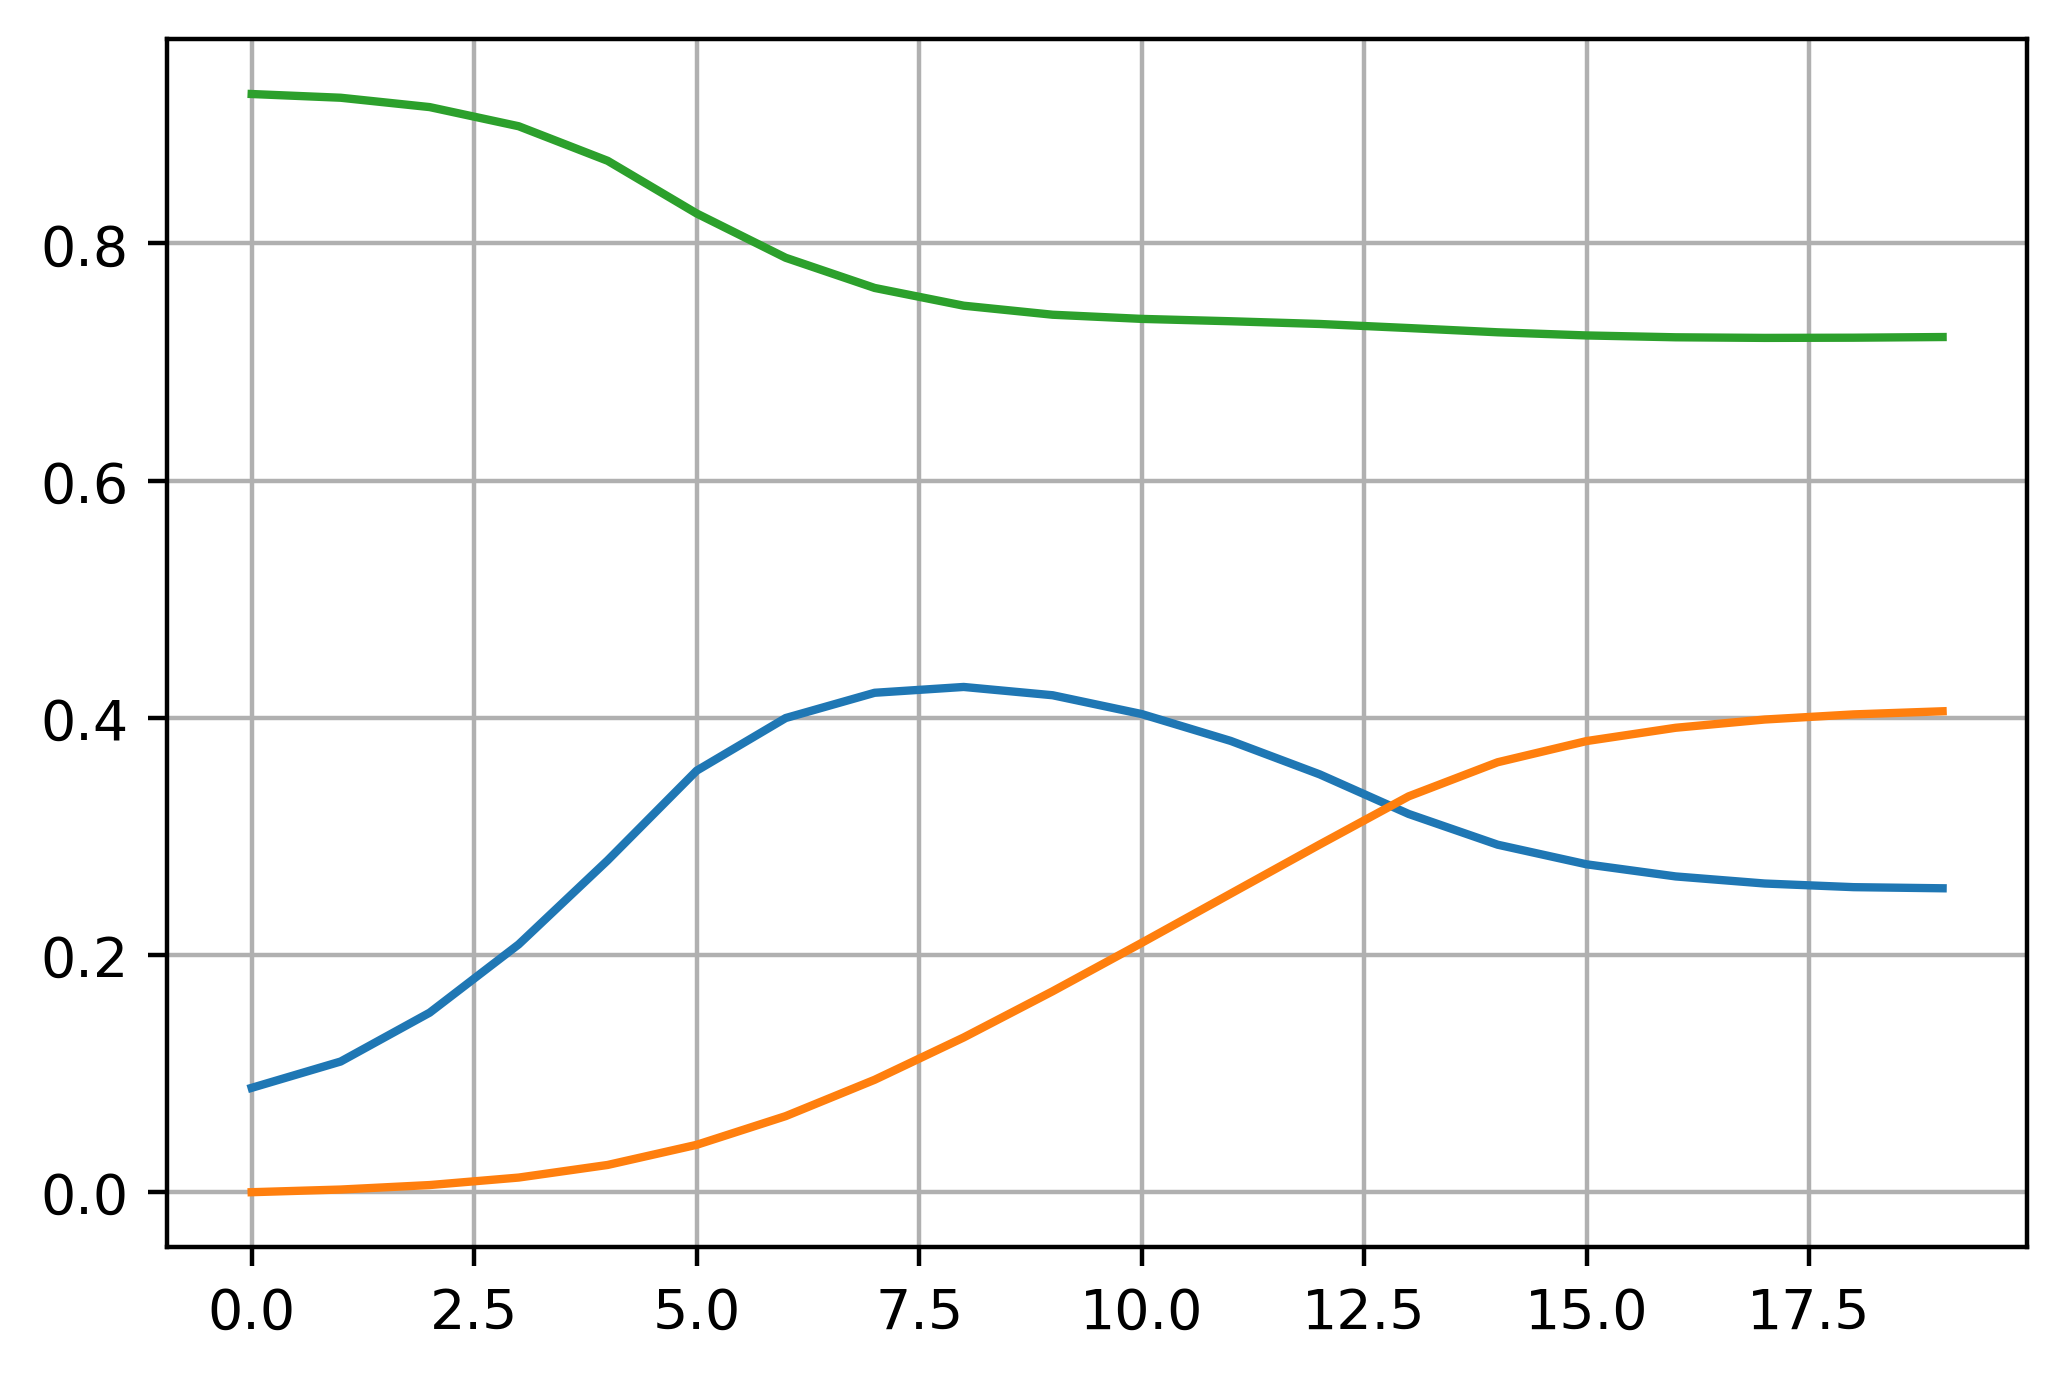

In [72]:
import matplotlib.pyplot as plt
import numpy as np
print(traj.keys())
p = np.squeeze(np.array(traj['p']))
plt.plot(p)